# **Importing Dependences**

In [ ]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import zipfile
import datetime
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# **Using GPU**

In [ ]:
# Checking whether we are using GPU
!nvidia-smi

Sun Jul 25 00:48:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Downloading and become one with the data**

In [ ]:
# Get data (10% of the 10 food classes from Food 101)
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
file_name = "/content/gdrive/MyDrive/dataset/10_food_classes_10_percent.zip"
zip_ref = zipfile.ZipFile(file_name, "r")
zip_ref.extractall()
zip_ref.close()

In [ ]:
# How many images in each folder?
# walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent

# **Creating data loaders (preparing the data)**

Use ImageDataGenerator class to load in out images in batches

In [ ]:
# Define global hyperparamters variables
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [ ]:
# Normalization of the images
train_dataGen = ImageDataGenerator(rescale=1./255)
test_dataGen = ImageDataGenerator(rescale=1./255)

In [ ]:
print("Training Images:")
train_data_10_percent = train_dataGen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("")
print("Testing Images:")
test_data = test_dataGen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training Images:
Found 750 images belonging to 10 classes.

Testing Images:
Found 2500 images belonging to 10 classes.


# **Setting up Callbacks (things to run whilst our model trains)**

In [ ]:
# Create tensorboard callback function
# (functionized because need to create a new one for each model)

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorBoard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorBoard_callback

# **Creating models using TensorFlow Hub**


## **Create and testing ResNET TensorFlow Hub feature extraction model**

In [ ]:
# ResNet50V2 feature vector URL
resNet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# EfficientNet0 feature vector URL
efficientNet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
def create_model(model_url, num_classes):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """

  # Download the pre-trained model from TensorFlow Hub and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))
  
  # Create the model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation="softmax",name="output_layer")
  ])

  return model

In [ ]:
# Create model
resNet_model = create_model(resNet_url, num_classes=train_data_10_percent.num_classes)

# Compile model
resNet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
# Fit the model
resNet_history = resNet_model.fit(train_data_10_percent,
                                  epochs=20,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", experiment_name="resNetV250")])

Saving TensorBoard log files to: tensorflow_hub/resNetV250/20210725-004910
Epoch 1/20
24/24 [==============================] - 54s 883ms/step - loss: 1.8930 - accuracy: 0.3813 - val_loss: 1.1445 - val_accuracy: 0.6368
Epoch 2/20
24/24 [==============================] - 17s 750ms/step - loss: 0.8587 - accuracy: 0.7387 - val_loss: 0.8261 - val_accuracy: 0.7320
Epoch 3/20
24/24 [==============================] - 17s 747ms/step - loss: 0.5929 - accuracy: 0.8440 - val_loss: 0.7358 - val_accuracy: 0.7568
Epoch 4/20
24/24 [==============================] - 18s 752ms/step - loss: 0.4578 - accuracy: 0.8893 - val_loss: 0.6785 - val_accuracy: 0.7768
Epoch 5/20
24/24 [==============================] - 18s 752ms/step - loss: 0.3593 - accuracy: 0.9267 - val_loss: 0.6557 - val_accuracy: 0.7848
Epoch 6/20
24/24 [==============================] - 17s 751ms/step - loss: 0.3000 - accuracy: 0.9360 - val_loss: 0.6497 - val_accuracy: 0.7784
Epoch 7/20
24/24 [==============================] - 17s 747ms/step 

In [ ]:
def plot_loss_curves(history): 
  """ 
  Returns separate loss curves for training and validation metrics. 
  """ 
  loss = history.history["loss"] 
  val_loss = history.history["val_loss"]

  epochs = range(len(history.history["loss"]))
 
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "validation_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()  

In [ ]:
def plot_accuracy_curves(history):
  """ 
  Returns separate accuracy curves for training and validation metrics. 
  """ 
  accuracy = history.history["accuracy"] 
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))
 
  plt.plot(epochs, accuracy, label = "accuracy")
  plt.plot(epochs, val_accuracy, label = "validation_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()  

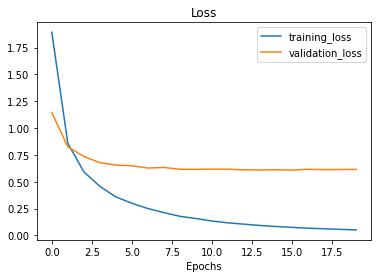

In [ ]:
plot_loss_curves(resNet_history)

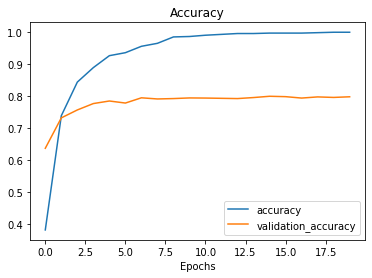

In [ ]:
plot_accuracy_curves(resNet_history)

In [ ]:
resNet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


## **Create and testing EfficientB0 TensorFlow Hub feature extraction model**

In [ ]:
# Create the efficientNet model

efficientNet = create_model(efficientNet_url, train_data_10_percent.num_classes)

In [ ]:
efficientNet.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
efficientNet_history=efficientNet.fit(train_data_10_percent,
                                      epochs=10,
                                      steps_per_epoch=len(train_data_10_percent),
                                      validation_data=test_data,
                                      validation_steps=len(test_data),
                                      callbacks=[create_tensorboard_callback("tensorflow_hub", "efficientNetb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientNetb0/20210725-014731
Epoch 1/10
24/24 [==============================] - 19s 816ms/step - loss: 0.2607 - accuracy: 0.9587 - val_loss: 0.4393 - val_accuracy: 0.8756
Epoch 2/10
24/24 [==============================] - 17s 711ms/step - loss: 0.2362 - accuracy: 0.9653 - val_loss: 0.4295 - val_accuracy: 0.8764
Epoch 3/10
24/24 [==============================] - 24s 1s/step - loss: 0.2191 - accuracy: 0.9720 - val_loss: 0.4264 - val_accuracy: 0.8740
Epoch 4/10
24/24 [==============================] - 17s 723ms/step - loss: 0.2001 - accuracy: 0.9733 - val_loss: 0.4168 - val_accuracy: 0.8792
Epoch 5/10
24/24 [==============================] - 17s 719ms/step - loss: 0.1847 - accuracy: 0.9800 - val_loss: 0.4112 - val_accuracy: 0.8796
Epoch 6/10
24/24 [==============================] - 17s 714ms/step - loss: 0.1717 - accuracy: 0.9800 - val_loss: 0.4065 - val_accuracy: 0.8808
Epoch 7/10
24/24 [==============================] - 17s 709ms/step

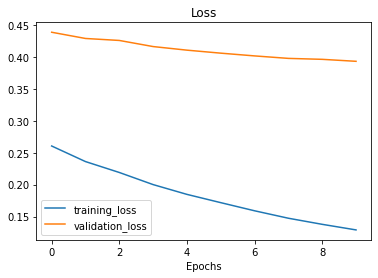

In [ ]:
plot_loss_curves(efficientNet_history)

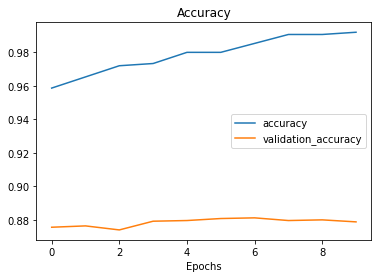

In [ ]:
plot_accuracy_curves(efficientNet_history)

In [ ]:
efficientNet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
efficientNet.layers

In [ ]:
efficientNet.layers[0]

In [ ]:
# How many layers does our efficientnetb0 feature extractor have?
len(efficientNet.layers[0].weights)

309

# **Different types of transfer learning**


*   **"As is" transfer learning** - using an existing model with no changes what so ever (e.g using ImageNet model on 1000 ImageNet classes, none of your own)
*   **"Feature extraction" transfer learning** - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food)
*   **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)





# **Comparing models using TensorBoard**

# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

# Check out experiments
!tensorboard dev list

# Delete an experiment
!tensorboard dev delete --experiment_id n6kd8XZ3Rdy1jSgSLH5WjA

# Check to see if experiments still exist
!tensorboard dev list